In [19]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
from sklearn import preprocessing
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import GraphicalLasso
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta
from spock_datastore.symboldb import SymbolDb
from spock_datastore.economicdb import EconomicDb
symbol_db = SymbolDb('http://api.leadinfo.com.tw/api/v1/')
economic_db = EconomicDb('http://api.leadinfo.com.tw/api/v1/')

In [11]:
def calculate_portfolio_var(w,covariance):
    w = np.matrix(w)
    return (w*covariance*w.T)[0,0]

### graphical lasso - shrinkage the covariance-variance matrix ###

In [2]:
symbols = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DWDP','XOM','GS','HD','INTC','IBM','JNJ','JPM','MCD','MRK','MSFT'
          ,'NKE','PFE','PG','TRV','UNH','UTX','VZ','WMT','DIS']
tot = pd.DataFrame()
tot_month = pd.DataFrame()
for symbol in symbols:
    y = symbol_db.dataReader(symbol, datetime.datetime(2004,1,1), datetime.datetime.today(), 'D', 'db') ['Adj Close']
    tot = pd.concat([tot, y],axis=1)
    yy = y.groupby(pd.Grouper(freq='M')).last()
    tot_month = pd.concat([tot_month, yy],axis=1)
tot.columns = symbols
tot_month.columns = symbols

In [4]:
return_month = tot_month.pct_change(1)
return_month.index = return_month.index.shift(-1, freq = 'MS')
return_month.head(3)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DWDP,XOM,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,DIS
2004-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,-0.013529,0.030478,0.060832,0.038802,-0.030462,0.023162,-0.099183,0.014622,0.036234,0.033832,...,-0.040506,0.051568,0.000546,0.014147,0.014479,0.018397,-0.035901,0.039881,0.106035,0.105417
2004-03-01,0.049346,-0.029390,0.129901,-0.053032,0.043828,-0.006452,0.017703,0.006805,-0.073384,-0.013754,...,-0.060309,0.063128,-0.043656,0.023120,-0.063875,0.039355,-0.063077,-0.046700,0.002183,-0.058047


In [22]:
all_date = pd.date_range(datetime.datetime(2006,4,1), datetime.datetime(2019,1,1), freq = 'MS').tolist()
total_ret_gl = pd.DataFrame()
for d in all_date:
    tmp_tot = tot[:d]
    tmp_tot = tmp_tot.fillna(method = 'ffill')
    tmp_tot = tmp_tot.fillna(method = 'bfill')
#     tmp_tot = preprocessing.scale(tmp_tot) #scale
    cov_gl = GraphicalLassoCV().fit(tmp_tot.iloc[-60:]) #five years
    covariance_gl = cov_gl.covariance_
    w0= np.ones([28,1]) / 28
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})
    res= minimize(calculate_portfolio_var, w0, args=covariance_gl, method='SLSQP',constraints=cons)
    w_g = res.x
    ret = (return_month[d:d] * w_g).sum(axis=1)
    total_ret_gl = pd.concat([total_ret_gl, ret], axis=0)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

### LedoitWolf

In [14]:
all_date = pd.date_range(datetime.datetime(2006,4,1), datetime.datetime(2019,1,1), freq = 'MS').tolist()
total_ret_lf = pd.DataFrame()
total_lf_cov = []
for d in all_date:
    tmp_tot = tot[:d]
    tmp_tot = tmp_tot.iloc[-60:].fillna(method = 'ffill')
    tmp_tot = tmp_tot.fillna(method = 'bfill')
    cov_lf = LedoitWolf().fit(tmp_tot)
    covariance_lf = cov_lf.covariance_
    total_lf_cov.append(covariance_lf)
    w0= np.ones([28,1]) / 28
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})
    res= minimize(calculate_portfolio_var, w0, args=covariance_lf, method='SLSQP',constraints=cons)
    w_g = res.x
    ret = (return_month[d:d] * w_g).sum(axis=1)
    total_ret_lf = pd.concat([total_ret_lf, ret], axis=0)

### Concord

In [15]:
def BIC(x, w):
    n,p = x.shape
    bic = []
    for i in range(p):
        rss_i = []
        for k in range(n):
            rss_i_k = (x[k,i] * 2 - sum(w[i,:] * x[k,:] / w[i,i]))**2
            rss_i.append(rss_i_k)
        rss_i = sum(rss_i)
        bic_i = n * np.log(rss_i) + np.log(n) * (np.count_nonzero(w[i,:]))
        bic.append(bic_i)
    bic = sum(bic)
    return bic

In [16]:
def concord(x):
    S = np.dot(x.T,x) / x.shape[0]
    W_old = np.linalg.inv(S)
    r_max = 100
    r=0
    con = False
    n = x.shape[1]
    tol = 0.001
    tot_bic = {}
    for lamda in [1.,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        while r<r_max and con == False:
            W = W_old.copy()
            # update partial covariance
            for i in range(n):
                for j in range(i+1,n):
                    soft_x = (W[i,:] * S[j,:]).sum() + (W[:,j] * S[i,:]).sum() - W[i,j] * S[j,j] - W[i,j] * S[i,i]
                    W[i,j] = np.sign(-soft_x) * max([0,abs(soft_x)-lamda/n]) / (S[i,i] + S[j,j])
            i_lower = np.tril_indices(W.shape[1], -1)
            W[i_lower] = W.T[i_lower]
            # update partial variance
            for i in range(n):
                W[i,i] = (-((W[i,:] * S[i,:]).sum() - W[i,i]*S[i,i]) + np.sqrt(((W[i,:] * S[i,:]).sum()-W[i,i]*S[i,i])**2 + 4*S[i,i])) / (2 * S[i,i])
            r+=1
            if np.linalg.norm(W-W_old) < tol:
                con=True
            W_old = W.copy()
        bic = BIC(x, W)
        tot_bic[bic] = W
    return tot_bic[min(tot_bic.keys())]

In [25]:
all_date = pd.date_range(datetime.datetime(2006,4,1), datetime.datetime(2019,1,1), freq = 'MS').tolist()
total_ret_con = pd.DataFrame()
total_cov_con = []
total_w = []
for d in all_date:
    tmp_tot = tot[:d]
    tmp_tot = tmp_tot.iloc[-60:].fillna(method = 'ffill')
    tmp_tot = tmp_tot.fillna(method = 'bfill')
    tmp_tot = preprocessing.scale(tmp_tot)
    inv_cov_con = concord(tmp_tot)
    covariance_con = np.linalg.inv(inv_cov_con)
    w0= np.ones([tmp_tot.shape[1],1]) / tmp_tot.shape[1]
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})
    res= minimize(calculate_portfolio_var, w0, args=np.asmatrix(covariance_con), method='SLSQP',constraints=cons)
    w_g = res.x
    ret = (return_month[d:d] * w_g).sum(axis=1)
    print(d)
    total_ret_con = pd.concat([total_ret_con, ret], axis=0)
    total_cov_con.append(covariance_con)
    total_w.append(w_g)

2006-04-01 00:00:00
2006-05-01 00:00:00
2006-06-01 00:00:00
2006-07-01 00:00:00
2006-08-01 00:00:00
2006-09-01 00:00:00
2006-10-01 00:00:00
2006-11-01 00:00:00
2006-12-01 00:00:00
2007-01-01 00:00:00
2007-02-01 00:00:00
2007-03-01 00:00:00
2007-04-01 00:00:00
2007-05-01 00:00:00
2007-06-01 00:00:00
2007-07-01 00:00:00
2007-08-01 00:00:00
2007-09-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2007-10-01 00:00:00
2007-11-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2007-12-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2008-01-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2008-02-01 00:00:00
2008-03-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2008-07-01 00:00:00
2008-08-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2008-09-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2008-10-01 00:00:00
2008-11-01 00:00:00
2008-12-01 00:00:00
2009-01-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2009-02-01 00:00:00
2009-03-01 00:00:00
2009-04-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-01 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-01 00:00:00
2009-12-01 00:00:00
2010-01-01 00:00:00
2010-02-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2010-03-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2010-04-01 00:00:00
2010-05-01 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2010-09-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-01 00:00:00
2011-02-01 00:00:00
2011-03-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2011-04-01 00:00:00
2011-05-01 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2011-08-01 00:00:00
2011-09-01 00:00:00
2011-10-01 00:00:00
2011-11-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2011-12-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2012-01-01 00:00:00
2012-02-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2012-03-01 00:00:00
2012-04-01 00:00:00
2012-05-01 00:00:00
2012-06-01 00:00:00
2012-07-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2012-08-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2012-09-01 00:00:00
2012-10-01 00:00:00
2012-11-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2012-12-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2013-01-01 00:00:00
2013-02-01 00:00:00
2013-03-01 00:00:00
2013-04-01 00:00:00
2013-05-01 00:00:00
2013-06-01 00:00:00
2013-07-01 00:00:00
2013-08-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2013-09-01 00:00:00
2013-10-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2013-11-01 00:00:00
2013-12-01 00:00:00
2014-01-01 00:00:00
2014-02-01 00:00:00
2014-03-01 00:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-01 00:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2014-09-01 00:00:00
2014-10-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2014-11-01 00:00:00
2014-12-01 00:00:00
2015-01-01 00:00:00
2015-02-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2015-03-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2015-04-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2015-05-01 00:00:00
2015-06-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2015-07-01 00:00:00
2015-08-01 00:00:00
2015-09-01 00:00:00
2015-10-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2015-11-01 00:00:00
2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2017-05-01 00:00:00
2017-06-01 00:00:00
2017-07-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2017-08-01 00:00:00
2017-09-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2017-10-01 00:00:00
2017-11-01 00:00:00
2017-12-01 00:00:00
2018-01-01 00:00:00
2018-02-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2018-03-01 00:00:00
2018-04-01 00:00:00
2018-05-01 00:00:00
2018-06-01 00:00:00
2018-07-01 00:00:00
2018-08-01 00:00:00
2018-09-01 00:00:00
2018-10-01 00:00:00
2018-11-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2018-12-01 00:00:00


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2019-01-01 00:00:00


### Nomral covariance

In [26]:
all_date = pd.date_range(datetime.datetime(2006,4,1), datetime.datetime(2019,1,1), freq = 'MS').tolist()
total_ret_nor = pd.DataFrame()
for d in all_date:
    tmp_tot = tot[:d]
#     cov_gl = GraphicalLassoCV().fit(tmp_tot.iloc[-60:])
#     cov_lf = LedoitWolf().fit(tmp_tot.iloc[-60:].fillna(method='ffill'))
    covariance_nor = tmp_tot.iloc[-60:].cov()
    w0= np.ones([28,1]) / 28
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})
    res= minimize(calculate_portfolio_var, w0, args=np.asmatrix(covariance_nor), method='SLSQP',constraints=cons)
    w_g = res.x
    ret = (return_month[d:d] * w_g).sum(axis=1)
    total_ret_nor = pd.concat([total_ret_nor, ret], axis=0)

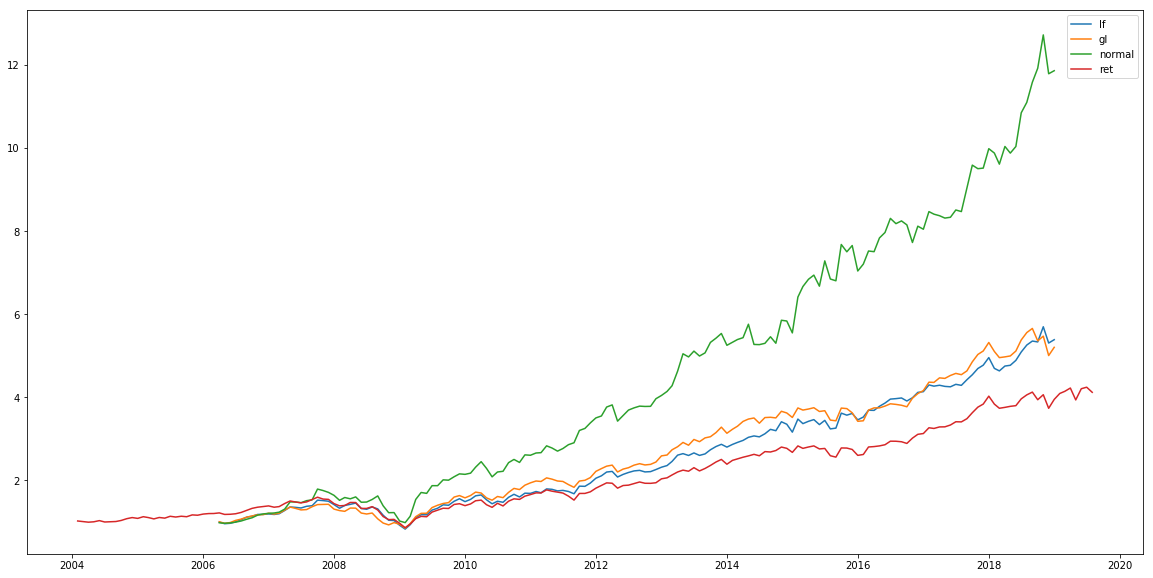

In [29]:
plt.figure(figsize=(20,10))
plt.plot((total_ret_lf+1).cumprod(), label = 'lf')
plt.plot((total_ret_gl+1).cumprod(), label = 'gl')
plt.plot((total_ret_nor+1).cumprod(), label = 'normal')
plt.plot((return_month.mean(axis=1).dropna() + 1).cumprod(), label = 'ret')
plt.legend()